In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA

from htc import set_font
from htc.settings import settings
from htc.utils.colors import darken_color, lighten_color
from htc.utils.visualization import add_range_fill, compress_html
from htc_projects.species.settings_species import settings_species
from htc_projects.species.species_evaluation import parameter_comparison
from htc_projects.species.tables import ischemic_table

pio.kaleido.scope.mathjax = None
set_font(font_family="sans")

## Performance Plots
### Kidney

In [2]:
def load_species_data(target_species: str, source_species: str) -> dict[str, pd.DataFrame]:
    table_name = f"test_table_{target_species}_perfusion"
    run_baseline = (
        settings.training_dir / "image" / f"{settings_species.model_timestamp}_baseline_{target_species}_nested-*-2"
    )
    run_projected = (
        settings.training_dir
        / "image"
        / f"{settings_species.model_timestamp}_projected-malperfusion_{source_species}2{target_species}_nested-*-2"
    )

    df, df_raw = parameter_comparison(
        {
            "in-species": run_baseline,
            "xeno-learning": run_projected,
        },
        table_name,
        param_name,
        target_labels=labels,
    )

    return {
        "df": df,
        "df_raw": df_raw,
    }


param_name = "median_sto2"
labels = settings_species.malperfused_labels_extended

targets = ["pig", "rat", "human", "human"]
sources = ["rat", "pig", "rat", "pig"]
species_data = {}
for target_species, source_species in zip(targets, sources, strict=True):
    species_data[(target_species, source_species)] = load_species_data(target_species, source_species)

In [3]:
network_colors = {
    "xeno-learning": settings_species.xeno_learning_color,
}

fig = make_subplots(
    2,
    2,
    subplot_titles=["rat2pig", "pig2rat", "rat2human", "pig2human"],
    shared_xaxes="all",
    shared_yaxes=True,
    vertical_spacing=0.23,
    horizontal_spacing=0.03,
)


def add_species_learning(target_species: str, source_species: str, row: int, col: int):
    df = species_data[(target_species, source_species)]["df"]
    df = df[df.label_name.isin(settings_species.malperfused_labels)]
    df_raw = species_data[(target_species, source_species)]["df_raw"]
    df_raw = df_raw[df_raw.label_name.isin(settings_species.malperfused_labels)]

    species_color = settings_species.species_colors[target_species]
    network_colors["in-species"] = species_color

    for network in df["network"].unique():
        df_network = df[df["network"] == network]
        df_network_raw = df_raw[df_raw["network"] == network]
        color = network_colors[network]

        for i, subject_name in enumerate(df_network_raw["subject_name"].unique()):
            df_subject = df_network_raw[df_network_raw["subject_name"] == subject_name]
            fig.add_trace(
                go.Scatter(
                    x=df_subject[param_name],
                    y=df_subject["dice_metric"],
                    hovertext=df_subject["image_name"],
                    marker_color=color,
                    # The first 13 markers are okish to distinguish but after that it gets difficult
                    # We start again after the first 13 and use open markers (+100)
                    marker_symbol=i if i < 13 else i % 13 + 100,
                    marker_size=8,
                    mode="markers",
                    name=network,
                    opacity=0.15,
                ),
                row=row,
                col=col,
            )

        mid_line = df_network[f"dice_metric_{param_name}_mean"].values.astype(float)
        valid = np.isfinite(mid_line)
        mid_line = mid_line[valid]
        add_range_fill(
            fig=fig,
            x=df_network[param_name][valid],
            top_line=df_network[f"dice_metric_{param_name}_q975"][valid],
            mid_line=mid_line,
            bottom_line=df_network[f"dice_metric_{param_name}_q025"][valid],
            color=color,
            row=row,
            col=col,
        )


add_species_learning(target_species="pig", source_species="rat", row=1, col=1)
add_species_learning(target_species="rat", source_species="pig", row=1, col=2)
add_species_learning(target_species="human", source_species="rat", row=2, col=1)
add_species_learning(target_species="human", source_species="pig", row=2, col=2)

fig.update_layout(showlegend=False)
fig.update_yaxes(title="<b>DSC</b>", title_standoff=12, col=1)
fig.update_xaxes(title="<b>StO<sub>2</sub> [a.u.]</b>", showticklabels=True)
fig.update_xaxes(title_standoff=8, row=1)
fig.update_layout(height=800, width=1200, template="plotly_white")
fig.update_layout(font_family="Libertinus Sans", font_size=16)
fig.update_annotations(font=dict(size=20))
fig.update_layout(margin=dict(l=0, r=0, t=22, b=0))
fig.write_image(settings_species.paper_dir / "perfusion_performance.pdf")
compress_html(settings_species.paper_dir / "perfusion_performance.html", fig)

### Other Organs

In [4]:
def add_species_learning_other(target_species: str, source_species: str, row: int) -> None:
    df = species_data[(target_species, source_species)]["df"]
    df_raw = species_data[(target_species, source_species)]["df_raw"]

    species_color = settings_species.species_colors[target_species]
    network_colors["in-species"] = species_color

    row_idx = row - 1
    for network in df["network"].unique():
        for i, label in enumerate(other_labels):
            col_idx = i % n_cols

            df_network = df[(df["network"] == network) & (df["label_name"] == label)]
            df_network_raw = df_raw[(df_raw["network"] == network) & (df_raw["label_name"] == label)]
            if network not in network_colors:
                continue
            color = network_colors[network]

            for i, subject_name in enumerate(sorted(df_network_raw["subject_name"].unique())):
                df_subject = df_network_raw[df_network_raw["subject_name"] == subject_name]
                fig.add_trace(
                    go.Scatter(
                        x=df_subject[param_name],
                        y=df_subject["dice_metric"],
                        hovertext=df_subject["image_name"],
                        marker_color=color,
                        # The first 13 markers are okish to distinguish but after that it gets difficult
                        # We start again after the first 13 and use open markers (+100)
                        marker_symbol=i if i < 13 else i % 13 + 100,
                        marker_size=8,
                        mode="markers",
                        name=network,
                        opacity=0.15,
                    ),
                    row=row_idx + 1,
                    col=col_idx + 1,
                )

            mid_line = df_network[f"dice_metric_{param_name}_mean"].values.astype(float)
            valid = np.isfinite(mid_line)
            mid_line = mid_line[valid]
            add_range_fill(
                fig=fig,
                x=df_network[param_name][valid],
                top_line=df_network[f"dice_metric_{param_name}_q975"][valid],
                mid_line=mid_line,
                bottom_line=df_network[f"dice_metric_{param_name}_q025"][valid],
                color=color,
                row=row_idx + 1,
                col=col_idx + 1,
            )


other_labels = [l for l in labels if l not in settings_species.malperfused_labels]
n_rows = 4
n_cols = len(other_labels)
fig = make_subplots(
    n_rows,
    n_cols,
    subplot_titles=other_labels,
    shared_xaxes="all",
    shared_yaxes="all",
    vertical_spacing=0.04,
    horizontal_spacing=0.03,
)

add_species_learning_other(target_species="pig", source_species="rat", row=1)
add_species_learning_other(target_species="rat", source_species="pig", row=2)
add_species_learning_other(target_species="human", source_species="rat", row=3)
add_species_learning_other(target_species="human", source_species="pig", row=4)

fig.update_layout(showlegend=False)
fig.update_yaxes(title="<b>DSC</b>", col=1)
fig.update_xaxes(title="<b>StO<sub>2</sub> [a.u.]</b>", row=n_rows)
fig.update_xaxes(showticklabels=True, tickvals=np.linspace(0.2, 1, 5))
fig.update_layout(height=1100, width=1100, template="plotly_white")
fig.update_layout(font_family="Libertinus Sans", font_size=17)
fig.update_annotations(font=dict(size=21))
fig.update_layout(margin=dict(l=0, r=0, t=22, b=0))
fig.write_image(settings_species.paper_dir / "perfusion_performance_organs.pdf")

## Distribution Plots

In [5]:
df_all = ischemic_table().query("label_name in @labels")
df_projections = pd.read_feather(settings_species.results_dir / "projections" / "projections_clear.feather")

pca = PCA(n_components=2, whiten=True)
pca_projections = pca.fit_transform(np.stack(df_all["median_normalized_spectrum"]))
df_all["pca_1"] = pca_projections[:, 0]
df_all["pca_2"] = pca_projections[:, 1]

pca_projections = pca.transform(np.stack(df_projections["median_normalized_spectrum"]))
df_projections["pca_1"] = pca_projections[:, 0]
df_projections["pca_2"] = pca_projections[:, 1]

pig rat 0.07035452127456665 0.9009758234024048
rat pig 0.05258142948150635 0.8222460746765137
human rat 0.07484447956085205 1.0
human pig 0.07484447956085205 1.0


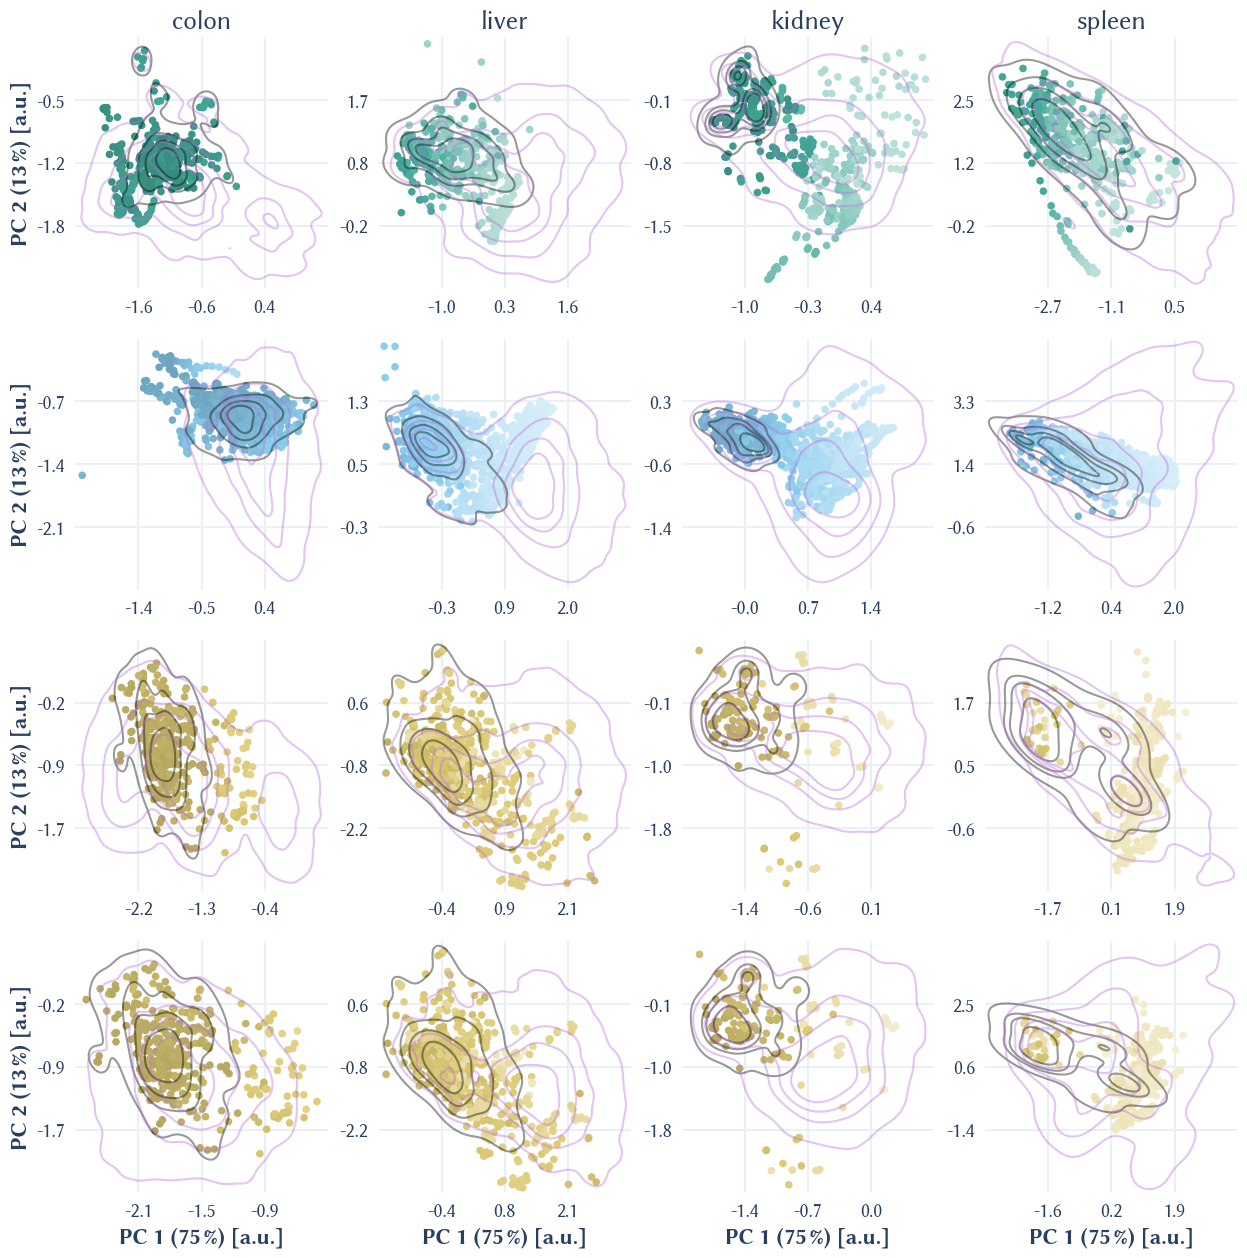

In [6]:
def tricolor_interpolate(base_color: str, value: float) -> str:
    assert 0 <= value <= 1
    max_darken = 0.2
    max_lighten = 0.7
    value_threshold = 0.5

    if value < value_threshold:
        # [0, 0.5] --> [0.5, 0] --> [1, 0] --> [max_darken, 0]
        return darken_color(base_color, max_darken * 2 * (value_threshold - value))
    else:
        # [0.5, 1] --> [0, 0.5] --> [0, 1] --> [0, max_lighten]
        return lighten_color(base_color, max_lighten * 2 * (value - value_threshold))


def add_species_projections(target_species: str, source_species: str, row: int) -> None:
    species_color = settings_species.species_colors[target_species]
    text_color = "#293F5E"
    grid_color = "#EBF0F7"

    # Species color scaling based on all labels
    df_raw = species_data[(target_species, source_species)]["df_raw"]
    df_as_all = df_all[(df_all.species_name == target_species) & (df_all.image_name.isin(df_raw.image_name))]
    param_min = df_as_all[param_name].min()
    param_max = df_as_all[param_name].max()
    print(target_species, source_species, param_min, param_max)

    for i, label in enumerate(labels):
        col = (i % n_cols) + 1
        ax = axes[row - 1][col - 1]

        df_xeno = df_projections[
            (df_projections.source_species == source_species)
            & (df_projections.target_species == target_species)
            & (df_projections.label_name == label)
        ]
        df_raw_label = df_raw[df_raw.label_name == label]
        df_real = df_all[
            (df_all.species_name == target_species)
            & (df_all.image_name.isin(df_raw_label.image_name))
            & (df_all.label_name == label)
        ]
        df_train = df_real[df_real.baseline_dataset]

        # KDE plots
        alpha = 0.4
        levels = 5
        sns.kdeplot(
            x=df_train["pca_1"], y=df_train["pca_2"], color="black", alpha=alpha, levels=levels, zorder=2, ax=ax
        )
        sns.kdeplot(
            x=df_xeno["pca_1"],
            y=df_xeno["pca_2"],
            color=network_colors["xeno-learning"],
            alpha=alpha,
            levels=levels,
            zorder=2,
            ax=ax,
        )

        # We want to consider the KDE lines in the axes margins
        # Extract the first line from the last kde plot
        first_line1 = ax.collections[0].get_paths()[0]
        first_line2 = ax.collections[1].get_paths()[0]
        points = np.concatenate([first_line1.vertices, first_line2.vertices])
        x_min, y_min = points.min(axis=0)
        x_max, y_max = points.max(axis=0)

        # Real points with StO2 encoded via the lightness
        colors = [
            tricolor_interpolate(species_color, 1 - (x - param_min) / (param_max - param_min))
            for x in df_real[param_name]
        ]
        ax.scatter(df_real["pca_1"], df_real["pca_2"], c=colors, s=20, zorder=1)

        margin = 0.1
        ax.set_xlim(min(df_real["pca_1"].min(), x_min) - margin, max(df_real["pca_1"].max(), x_max) + margin)
        ax.set_ylim(min(df_real["pca_2"].min(), y_min) - margin, max(df_real["pca_2"].max(), y_max) + margin)

        # Axes labels
        if col == 1:
            ax.set_ylabel(
                f"PC 2 ({pca.explained_variance_ratio_[1] * 100:.0f} %) [a.u.]", fontweight="bold", color=text_color
            )
        else:
            ax.set_ylabel(None)

        if row == n_rows:
            ax.set_xlabel(
                f"PC 1 ({pca.explained_variance_ratio_[0] * 100:.0f} %) [a.u.]", fontweight="bold", color=text_color
            )
        else:
            ax.set_xlabel(None)

        if row == 1:
            ax.set_title(label, color=text_color)

        # Exactly three ticks per subplot
        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()
        ax.xaxis.set_major_locator(plt.FixedLocator(np.linspace(x_min, x_max, 5)[1:-1]))
        ax.yaxis.set_major_locator(plt.FixedLocator(np.linspace(y_min, y_max, 5)[1:-1]))
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter("%.1f"))
        ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%.1f"))

        # Mimic the Plotly style
        ax.set_axisbelow(True)
        ax.grid(True, linestyle="-", linewidth=1.5, color=grid_color)
        ax.set_frame_on(False)
        ax.tick_params(colors=text_color, left=False, bottom=False)


n_rows = 4
n_cols = len(labels)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

add_species_projections(target_species="pig", source_species="rat", row=1)
add_species_projections(target_species="rat", source_species="pig", row=2)
add_species_projections(target_species="human", source_species="rat", row=3)
add_species_projections(target_species="human", source_species="pig", row=4)
fig.savefig(settings_species.paper_dir / "perfusion_projections_organs.pdf", bbox_inches="tight")

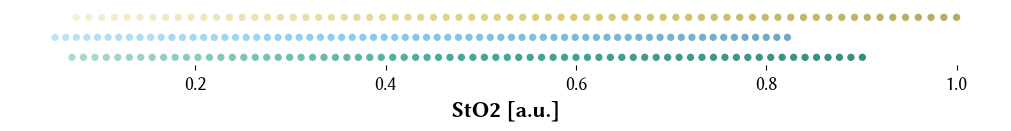

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 1.2), constrained_layout=True)
i = 0

for target_species, source_species in species_data.keys():
    if target_species == "human" and source_species == "rat":
        continue

    df_raw = species_data[(target_species, source_species)]["df_raw"]
    df_as_all = df_all[(df_all.species_name == target_species) & (df_all.image_name.isin(df_raw.image_name))]
    param_min = df_as_all[param_name].min()
    param_max = df_as_all[param_name].max()

    x = np.linspace(param_min, param_max, 70)
    species_color = settings_species.species_colors[target_species]
    colors = [tricolor_interpolate(species_color, value) for value in reversed(x)]

    ax.scatter(x=x, y=[i] * len(x), c=colors, s=18)
    i += 1

ax.yaxis.set_visible(False)
ax.margins(0.05, 0.2)
ax.set_xlabel("StO2 [a.u.]", fontweight="bold")
ax.set_frame_on(False)
fig.savefig(settings_species.paper_dir / "perfusion_projections_organs_legend.pdf")